In [ ]:
# 1. Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 2. Load dataset
df = pd.read_csv('diabetes_dataset.csv')

# 3. Data Preprocessing
# Encode categorical variables
df['gender'] = LabelEncoder().fit_transform(df['gender'])
df['smoking_history'] = LabelEncoder().fit_transform(df['smoking_history'])

# Drop missing values
df = df.dropna()

# 4. Feature Engineering
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 7. Model Development
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_test_scaled)
    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "classification_report": classification_report(y_test, y_pred)
    }
    print(f"\n{name} Classification Report:\n", results[name]["classification_report"])

# 8. Model Interpretability
# Feature Importance for Random Forest
rf = models["Random Forest"]
importances = rf.feature_importances_
feat_names = X.columns
plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feat_names)
plt.title("Random Forest Feature Importance")
plt.show()

# SHAP for interpretability (using Random Forest as example)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

# 9. Model Selection
print("\nModel Performance Summary:")
for name, metrics in results.items():
    print(f"{name}: Accuracy={metrics['accuracy']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, F1={metrics['f1']:.3f}, ROC_AUC={metrics['roc_auc']:.3f}")

# 10. Predictive System Example
def predict_diabetes(input_data, model, scaler):
    input_array = np.asarray(input_data).reshape(1, -1)
    input_scaled = scaler.transform(input_array)
    prediction = model.predict(input_scaled)
    return "Diabetic" if prediction[0] == 1 else "Not Diabetic"

# Example input (replace with real values as needed)
example = X.iloc[0].values
print("\nPrediction Example (Random Forest):", predict_diabetes(example, rf, scaler))


# =====================================================================================================================


# 11. Predict and Explain Function
# This function takes input data, a trained model, a scaler, and a SHAP explainer to predict and explain the model's decision.


def predict_and_explain(input_data, model, scaler, explainer, feature_names):
    # Prepare input
    input_array = np.asarray(input_data).reshape(1, -1)
    input_scaled = scaler.transform(input_array)
    # Predict probability and class
    if hasattr(model, "predict_proba"):
        risk = model.predict_proba(input_scaled)[0,1]
    else:
        # For SVM, use decision_function and sigmoid for probability estimate
        from scipy.special import expit
        risk = expit(model.decision_function(input_scaled))[0]
    prediction = model.predict(input_scaled)[0]
    # SHAP explanation
    shap_values = explainer.shap_values(input_scaled)
    # For Random Forest, shap_values is a list (for each class)
    shap_contrib = shap_values[1][0] if isinstance(shap_values, list) else shap_values[0]
    # Print prediction and risk
    print(f"Predicted risk of diabetes: {risk:.2f}")
    print("Prediction:", "Diabetic" if prediction == 1 else "Not Diabetic")
    # Show feature contributions
    print("\nFeature contributions to this prediction:")
    for name, value in sorted(zip(feature_names, shap_contrib), key=lambda x: abs(x[1]), reverse=True):
        print(f"{name}: {value:+.3f}")
    # Visualize with SHAP force plot (optional, for Jupyter)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], shap_contrib, input_scaled, feature_names=feature_names))

# Example usage with Random Forest
input_example = X.iloc[0].values
rf_explainer = shap.TreeExplainer(rf)
predict_and_explain(input_example, rf, scaler, rf_explainer, X.columns)


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.94      0.69      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.96      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.64      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.81      0.86     20000
weighted avg       0.96      0.96      0.96     20000



In [ ]:
!pip install shap
!pip install seaborn

     |████████████████████████████████| 997 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.4 MB 3.3 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
onnxruntime 1.19.2 requires numpy>=1.21.6, but you have numpy 1.20.3 which is incompatible.


1. Data Collection: Creating a synthetic dataset for demonstration.
Dataset shape: (1000, 9)
First 5 rows of the dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin        BMI  \
0            6      138             59             14      357  19.457932   
1           14      125             99             20      727  19.419490   
2           10      102             52             30      563  43.470207   
3            7      105            119             44      782  47.348900   
4            6      150            100             21      484  31.123444   

   DiabetesPedigreeFunction  Age  Outcome  
0                  2.137813   70        1  
1                  0.910437   30        1  
2                  0.155573   47        0  
3                  1.883217   75        1  
4                  2.018953   21        1  
--------------------------------------------------
2. Feature Engineering: Identifying features and target variable.
Features after scaling (first 5 ro

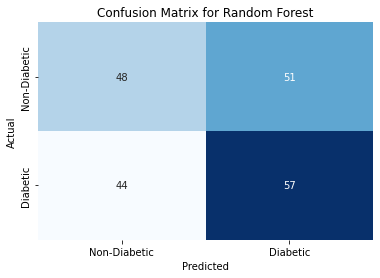

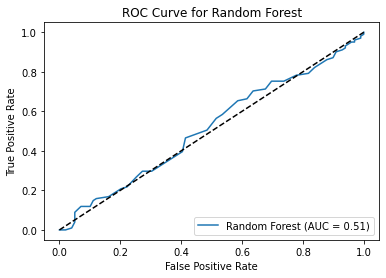


--- Training Logistic Regression ---
  Accuracy: 0.5300
  Precision: 0.5354
  Recall: 0.5248
  F1-Score: 0.5300
  AUC-ROC: 0.5235
  Confusion Matrix:
[[53 46]
 [48 53]]


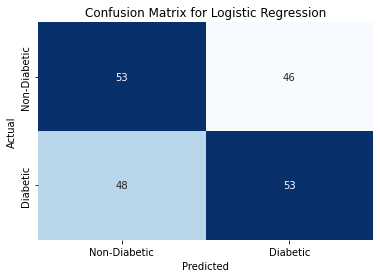

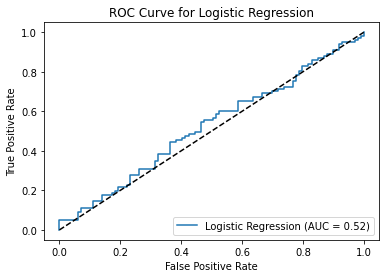


--- Training Support Vector Machine ---
  Accuracy: 0.5600
  Precision: 0.5596
  Recall: 0.6040
  F1-Score: 0.5810
  AUC-ROC: 0.4329
  Confusion Matrix:
[[51 48]
 [40 61]]


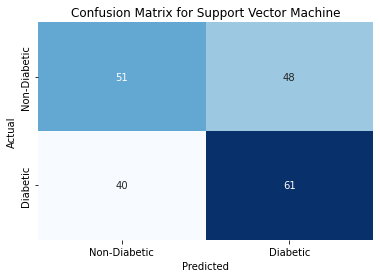

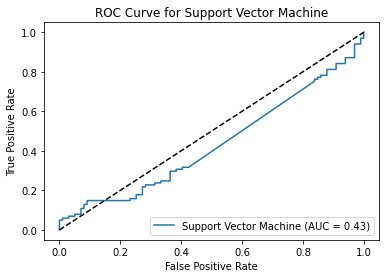

--------------------------------------------------
5. Interpretability Integration: Applying SHAP, LIME, and Feature Importance.

--- SHAP Explanations ---

SHAP for Random Forest:


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular
import numpy as np

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Collection ---
# For demonstration, we'll use a placeholder for data loading.
# In a real scenario, you would load your diabetes dataset here.
# Example: df = pd.read_csv('your_diabetes_dataset.csv')

# Let's create a synthetic dataset for demonstration purposes
# In a real scenario, replace this with your actual data loading
print("1. Data Collection: Creating a synthetic dataset for demonstration.")
np.random.seed(42)
num_samples = 1000
data = {
    'Pregnancies': np.random.randint(0, 17, num_samples),
    'Glucose': np.random.randint(70, 200, num_samples),
    'BloodPressure': np.random.randint(50, 120, num_samples),
    'SkinThickness': np.random.randint(10, 60, num_samples),
    'Insulin': np.random.randint(0, 850, num_samples),
    'BMI': np.random.uniform(15.0, 50.0, num_samples),
    'DiabetesPedigreeFunction': np.random.uniform(0.07, 2.5, num_samples),
    'Age': np.random.randint(20, 80, num_samples),
    'Outcome': np.random.randint(0, 2, num_samples) # 0 for non-diabetic, 1 for diabetic
}
df = pd.DataFrame(data)

print(f"Dataset shape: {df.shape}")
print("First 5 rows of the dataset:")
print(df.head())
print("-" * 50)

# --- 2. Feature Engineering ---
# This is a crucial step. For simplicity, we'll assume the columns in our
# synthetic data are the relevant features. In a real-world scenario,
# you might create new features (e.g., ratios, interactions) or handle
# missing values, outliers, etc.

print("2. Feature Engineering: Identifying features and target variable.")
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Scale numerical features (important for Logistic Regression and SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Features after scaling (first 5 rows):")
print(X_scaled.head())
print("-" * 50)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")
print("-" * 50)

# --- 3. Model Development ---
print("3. Model Development: Initializing and training models.")

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear'),
    'Support Vector Machine': SVC(probability=True, random_state=42) # probability=True for AUC-ROC
}

# Hyperparameter tuning (optional but recommended)
# For demonstration, we'll use simple hyperparams or default ones.
# You might want to use GridSearchCV for more exhaustive tuning.

# Example for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20]
# }
# grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='roc_auc')
# grid_search_rf.fit(X_train, y_train)
# models['Random Forest'] = grid_search_rf.best_estimator_
# print(f"Best params for Random Forest: {grid_search_rf.best_params_}")

# Example for Logistic Regression
# param_grid_lr = {
#     'C': [0.01, 0.1, 1, 10]
# }
# grid_search_lr = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), param_grid_lr, cv=5, scoring='roc_auc')
# grid_search_lr.fit(X_train, y_train)
# models['Logistic Regression'] = grid_search_lr.best_estimator_
# print(f"Best params for Logistic Regression: {grid_search_lr.best_params_}")

# Example for SVM
# param_grid_svm = {
#     'C': [0.1, 1, 10],
#     'kernel': ['rbf', 'linear']
# }
# grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid_svm, cv=5, scoring='roc_auc')
# grid_search_svm.fit(X_train, y_train)
# models['Support Vector Machine'] = grid_search_svm.best_estimator_
# print(f"Best params for Support Vector Machine: {grid_search_svm.best_params_}")


print("-" * 50)

# --- 4. Training and Validation ---
print("4. Training and Validation: Training models and assessing performance.")
results = {}

for name, model in models.items():
    print(f"\n--- Training {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'confusion_matrix': cm
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc_roc:.4f}" if isinstance(auc_roc, float) else f"  AUC-ROC: {auc_roc}")
    print("  Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Diabetic', 'Diabetic'], yticklabels=['Non-Diabetic', 'Diabetic'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {name}')
    plt.show()

    # Plot ROC Curve
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_roc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {name}')
        plt.legend(loc='lower right')
        plt.show()

print("-" * 50)

# --- 5. Interpretability Integration ---
print("5. Interpretability Integration: Applying SHAP, LIME, and Feature Importance.")

# SHAP (SHapley Additive exPlanations)
print("\n--- SHAP Explanations ---")
for name, model in models.items():
    print(f"\nSHAP for {name}:")
    if name == 'Support Vector Machine':
        # SHAP for SVM can be more complex, especially for non-linear kernels.
        # For a linear kernel, you can use the coef_ attribute for feature importance.
        # For RBF kernel, KernelExplainer or TreeExplainer (if converted to tree)
        # might be used, but they can be computationally intensive or require approximations.
        # Here, we'll use KernelExplainer for generality, but it can be slow for large datasets.
        # For better performance with SVC, consider LinearSVC or LogisticRegression.

        try:
            # For KernelExplainer, you need a background dataset
            # A common approach is to use a small sample of the training data
            # Or use a single background observation for speed
            if hasattr(model, 'predict_proba'): # Ensure probability output for explainer
                explainer = shap.KernelExplainer(model.predict_proba, X_train.sample(100, random_state=42) if len(X_train) > 100 else X_train)
                shap_values = explainer.shap_values(X_test.iloc[:50]) # Explain a subset for speed
                shap.summary_plot(shap_values[1], X_test.iloc[:50], feature_names=X.columns, show=False)
                plt.title(f'SHAP Summary Plot for {name}')
                plt.show()
                print("Note: SHAP KernelExplainer can be computationally intensive for large datasets.")
            else:
                print(f"  {name} does not support predict_proba, skipping SHAP KernelExplainer.")
        except Exception as e:
            print(f"  Could not generate SHAP for {name}: {e}")

    else: # Tree-based models (Random Forest) and Linear models (Logistic Regression)
        if name == 'Random Forest':
            explainer = shap.TreeExplainer(model)
        else: # Logistic Regression
            explainer = shap.LinearExplainer(model, X_train)

        shap_values = explainer.shap_values(X_test)
        if name == 'Random Forest':
            shap.summary_plot(shap_values[1], X_test, feature_names=X.columns, show=False) # For classification, shap_values is a list of arrays (one for each class)
        else: # Logistic Regression
            shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
        plt.title(f'SHAP Summary Plot for {name}')
        plt.show()

# LIME (Local Interpretable Model-agnostic Explanations)
print("\n--- LIME Explanations (for a single instance) ---")
# Choose an instance to explain (e.g., the first test instance)
instance_to_explain_idx = 0
instance = X_test.iloc[instance_to_explain_idx]

for name, model in models.items():
    print(f"\nLIME for {name} (Instance {instance_to_explain_idx}):")
    try:
        if hasattr(model, 'predict_proba'):
            explainer = lime.lime_tabular.LimeTabularExplainer(
                training_data=X_train.values,
                feature_names=X.columns.tolist(),
                class_names=['Non-Diabetic', 'Diabetic'],
                mode='classification'
            )
            explanation = explainer.explain_instance(
                data_row=instance.values,
                predict_fn=model.predict_proba,
                num_features=len(X.columns)
            )
            print(f"  Prediction for instance: {model.predict(instance.to_frame().T)[0]} (Actual: {y_test.iloc[instance_to_explain_idx]})")
            explanation.as_list()
            fig = explanation.as_pyplot_figure()
            fig.suptitle(f'LIME Explanation for {name}')
            plt.show()
        else:
            print(f"  {name} does not support predict_proba, skipping LIME.")
    except Exception as e:
        print(f"  Could not generate LIME for {name}: {e}")

# Feature Importance (for applicable models)
print("\n--- Feature Importance ---")
for name, model in models.items():
    print(f"\nFeature Importance for {name}:")
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X.columns
        df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        df_importance = df_importance.sort_values(by='Importance', ascending=False)
        print(df_importance)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=df_importance)
        plt.title(f'Feature Importance for {name}')
        plt.show()
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0]) # For binary classification, take absolute value of coefficients
        feature_names = X.columns
        df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        df_importance = df_importance.sort_values(by='Importance', ascending=False)
        print(df_importance)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=df_importance)
        plt.title(f'Coefficient Magnitude for {name}')
        plt.show()
    else:
        print(f"  {name} does not have a direct feature_importances_ or coef_ attribute.")

print("-" * 50)

# --- 6. Model Selection ---
print("6. Model Selection: Comparing models based on metrics and interpretability.")

best_model_name = None
best_auc_roc = -1

print("\n--- Model Performance Summary ---")
for name, metrics in results.items():
    print(f"\nModel: {name}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1-Score: {metrics['f1_score']:.4f}")
    print(f"  AUC-ROC: {metrics['auc_roc']:.4f}" if isinstance(metrics['auc_roc'], float) else f"  AUC-ROC: {metrics['auc_roc']}")

    if isinstance(metrics['auc_roc'], float) and metrics['auc_roc'] > best_auc_roc:
        best_auc_roc = metrics['auc_roc']
        best_model_name = name

print(f"\nBased on AUC-ROC, the best performing model is: {best_model_name}")
print("However, model selection also depends on project needs and interpretability insights.")
print("For instance, if transparency is paramount, Logistic Regression might be preferred even with slightly lower performance.")
print("-" * 50)

# --- Deployment and Evaluation (Conceptual) ---
print("Deployment and Evaluation (Conceptual):")
print("Once the best model is selected, it would be saved (e.g., using pickle or joblib).")
print("Then, it can be loaded and used to make predictions on new, unseen data.")
print("Ongoing monitoring and re-evaluation of the deployed model's performance in a real-world setting are crucial.")

# Example of saving and loading the best model (conceptual)
# import joblib
#
# if best_model_name:
#     selected_model = models[best_model_name]
#     joblib.dump(selected_model, f'{best_model_name.replace(" ", "_").lower()}_diabetes_predictor.pkl')
#     print(f"\nSelected model ({best_model_name}) saved as '{best_model_name.replace(' ', '_').lower()}_diabetes_predictor.pkl'")
#
#     # To load the model later:
#     # loaded_model = joblib.load(f'{best_model_name.replace(" ", "_").lower()}_diabetes_predictor.pkl')
#     # new_data_prediction = loaded_model.predict(new_data_scaled)